# Download essential libraries

In [ ]:
! pip install accelerate
! pip install datasets
! pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 2.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

# Load the essential libraries

In [ ]:
from datasets import load_dataset
from transformers import DetrImageProcessor, DetrForObjectDetection
from transformers import AutoImageProcessor,AutoModelForObjectDetection
import torch
from PIL import Image,ImageDraw
import requests
import matplotlib.pyplot as plt
from google.colab import drive
import cv2
import numpy as np
import glob  # For reading files
import os
from tqdm.auto import tqdm

# Load the dataset

In [ ]:
wider_face = load_dataset('wodeyuanbukongda/detr_format')
wider_face = wider_face['train'].select(range(0,1000))
wider_face

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/16102 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'image_id', 'area', 'bbox', 'label'],
    num_rows: 1000
})

# Load the model before fine_tuning to show the result

In [ ]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image_2 = wider_face[0]['image']
# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

inputs = processor(images=image_2, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image_2.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

draw = ImageDraw.Draw(image_2)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=5)
    draw.text((x, y), model.config.id2label[label.item()], fill="white",font_size=52)
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.60k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Detected person with confidence 0.97 at location [268.9, 24.67, 756.97, 1246.88]


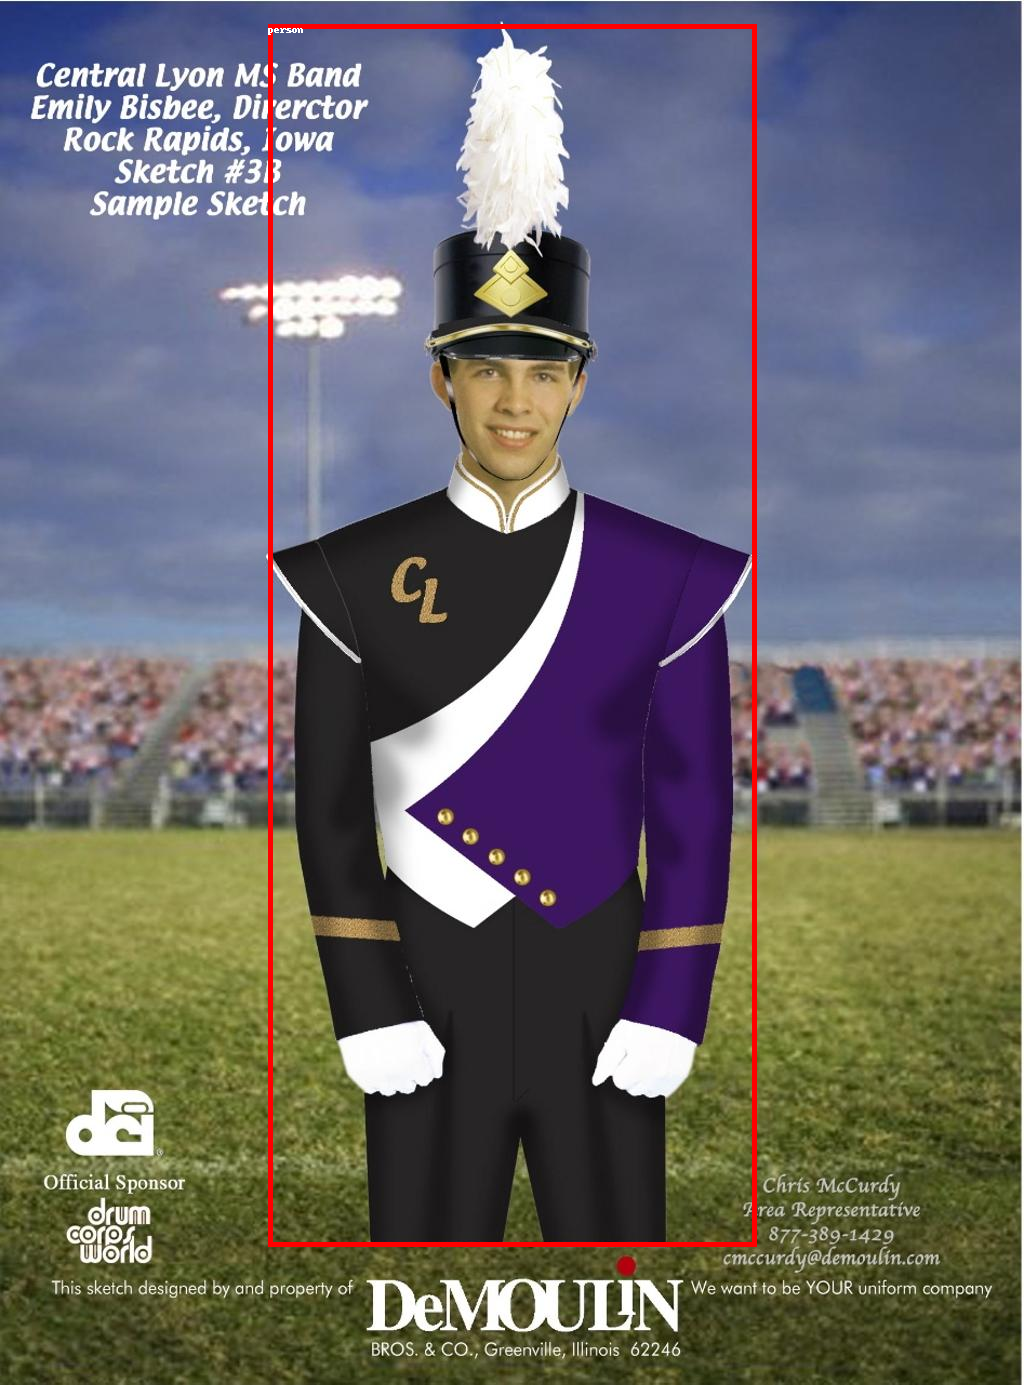

In [ ]:
image_2

# Result after fine-tunning

## Load the parameters

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
checkpoint = "facebook/detr-resnet-50"
id2label = {0:'human_face'}
label2id = {'human_face':0}
id2label,label2id

processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    num_labels=1,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)
checkpoint = torch.load(r'/content/drive/MyDrive/MSML640/checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

## Predicted Output

In [ ]:
image_1 = wider_face[0]['image']
#image = Image.open('/content/drive/MyDrive/2024Spring/640ComputerVision/YOLO/Image/0122.jpg')
# image_1 = Image.open('/content/drive/MyDrive/MSML640_final_project_folder/input_images/0001.jpg')
model.eval()
with torch.no_grad():
    inputs = processor(images=image_1, return_tensors="pt")
    pixel_values = inputs['pixel_values'].to(device)
    pixel_mask = inputs['pixel_mask'].to(device)
    inputs = {'pixel_values':pixel_values,'pixel_mask':pixel_mask}
    outputs = model(**inputs)
    target_sizes = torch.tensor([image_1.size[::-1]])
    results = processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

In [ ]:
draw = ImageDraw.Draw(image_1)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=5)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image_1

# Groundtrue Output

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x1385 at 0x7D9E4AEB0C10>, 'image_id': 0, 'area': [18178.0], 'bbox': [[449.0, 330.0, 122.0, 149.0]], 'label': [0.0]}


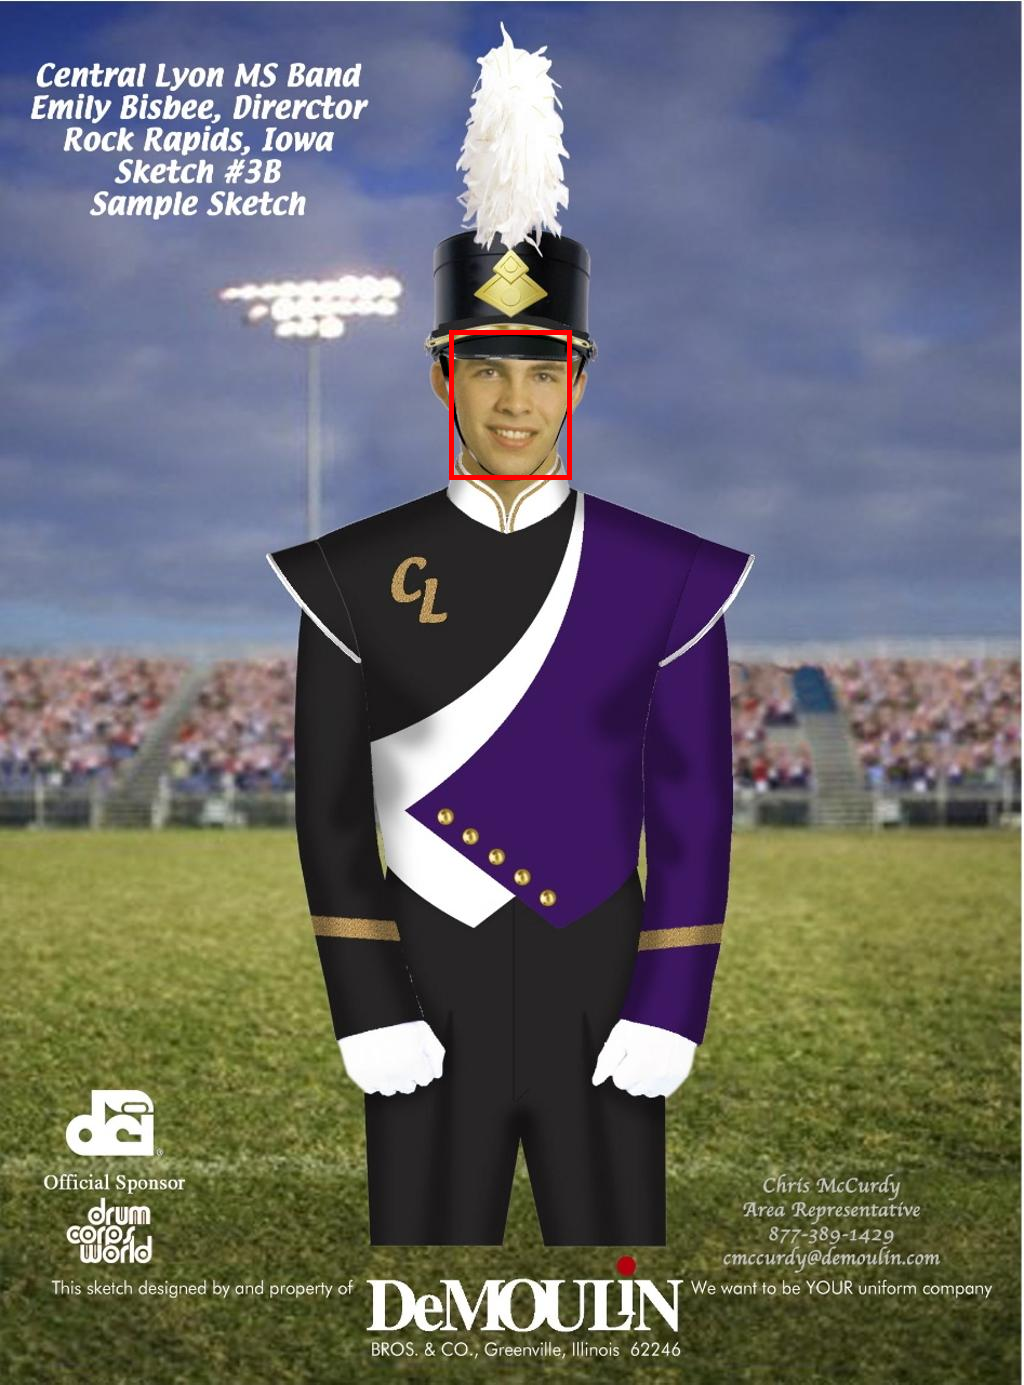

In [ ]:
image = wider_face[0]["image"]
annotations = wider_face[0]
print(annotations)
draw = ImageDraw.Draw(image)

for i in range(len(annotations["label"])):
    # Get the bbox coordinate
    box = annotations["bbox"][i]
    # Get the correspond class_id
    x, y, w, h = tuple(box)
    # Check if coordinates are normalized or not
    if max(box) > 1.0:
        # Coordinates are un-normalized, no need to re-scale them
        # Top left corner
        x1, y1 = int(x), int(y)
        # Bottom right corner
        x2, y2 = int(x + w), int(y + h)
    else:
        # Coordinates are normalized, re-scale them
        x1 = int(x * width)
        y1 = int(y * height)
        x2 = int((x + w) * width)
        y2 = int((y + h) * height)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=5)
image

# Video downsampling and regenerate

In [ ]:
input_video = "/content/drive/MyDrive/MSML640/IMG_1287.mp4" # Path of the video
placehold_images_folder = "/content/drive/MyDrive/MSML640/input_images" # Path for the image folder (RAM issues)

model.to(device)

# Interpolation Function
def interpolate_frames(frame1, frame2, num_intermediate_frames):
    interpolated_frames = []
    for i in range(1, num_intermediate_frames + 1):
        alpha = i / (num_intermediate_frames + 1)
        interpolated_frame = cv2.addWeighted(frame1, 1 - alpha, frame2, alpha, 0)
        interpolated_frames.append(interpolated_frame)
    return interpolated_frames
def process_batch(batch):
    # Load images
    images = [Image.open(img_path).convert("RGB") for img_path in batch]
    inputs = processor(images=images, return_tensors="pt")  # Adjust for batch processing

    # Process with the model
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs.to(model.device))  # Ensure tensors are on the same device as model
        target_sizes = torch.tensor([img.size[::-1] for img in images]).to(model.device)
        results = processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)

    # Convert images to BGR and store
    processed_images = []
    for img, result in zip(images, results):
        draw = ImageDraw.Draw(img)
        if result["scores"].nelement() > 0:
            for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
                box = [round(b, 2) for b in box.tolist()]
                x, y, x2, y2 = box
                draw.rectangle((x, y, x2, y2), outline="red", width=5)
                draw.text((x, y), model.config.id2label[label.item()], fill="white")
        img_np = np.array(img)
        img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
        processed_images.append(img_bgr)
    return processed_images


def main(model_type, input_video,placehold_images_folder, FPS):

  if not os.path.exists(placehold_images_folder):
    os.makedirs(placehold_images_folder)
    print(f"Created directory: {placehold_images_folder}")
  else:
    print(f"Directory already exists: {placehold_images_folder}")
  # Video downsampling
  # Define a video capture object
  vidcap = cv2.VideoCapture(input_video)

  # Capture video frame by frame
  success, image = vidcap.read()
  print(f"Capturing the video: {success}")

  # Declare the variable with value 0
  count = 0

  # Creating a loop for running the video
  # and saving all the frames
  while success:
      resize = cv2.resize(image,(1080,1920))
      cv2.imwrite(placehold_images_folder + "/%04d.jpg" % count, resize)
      count+=1
      success,image = vidcap.read()

  print(f"Total frames processed: {count}")

  output_video = '/content/drive/MyDrive/MSML640/output.mp4'  # Output video file


  # List all the image file
  # List: /content/drive/MyDrive/MSML640/input_images/0000.jpg
  image_files = glob.glob(os.path.join(placehold_images_folder, '*.jpg'))  # Assuming images are in JPG format

  # sort the image in terms of the sequence
  image_files.sort()  # Sort the images to ensure correct order

  # Assuming 'image_files' is a list of image file paths
  batch_size = 8  # You can adjust the batch size depending on your GPU memory

  # Filter out every second image
  filtered_images = [img for index, img in enumerate(image_files) if int(img[-8:-4]) % 2 != 0]

  # Create batches
  image_batches = [filtered_images[i:i + batch_size] for i in range(0, len(filtered_images), batch_size)]

  # Process all batches
  keyframes = []
  for batch in tqdm(image_batches):
      keyframes.extend(process_batch(batch))

  # Perform interpolation between keyframes
  interpolated_frames = []
  for i in range(len(keyframes) - 1):
      num_intermediate_frames = 1  # Number of intermediate frames between each pair of keyframes
      interpolated_frames.extend(interpolate_frames(keyframes[i], keyframes[i + 1], num_intermediate_frames))

  reconstructed_video_frames = []
  for i in range(0,len(keyframes)-1):
      reconstructed_video_frames.append(keyframes[i])
      reconstructed_video_frames.append(interpolated_frames[i])

  first_image = cv2.imread(image_files[0])
  frame_size = (first_image.shape[1], first_image.shape[0])
  # Define the codec and create VideoWriter object
  fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Adjust codec if needed
  out = cv2.VideoWriter(output_video, fourcc, 30, frame_size)

  for img_file in reconstructed_video_frames:
      img = img_file
      # Check if the images are the same size as frame_size, resize if different
      if img.shape[1] != frame_size[0] or img.shape[0] != frame_size[1]:
          img = cv2.resize(img, frame_size)
      # Write the frame into the file 'output_video'
      out.write(img)

  # Release everything when done
  out.release()

main(True, input_video,placehold_images_folder, 100)

# World's largest selfie

In [ ]:
# image_1 = wider_face[0]['image']
image_1 = Image.open('/content/drive/MyDrive/MSML640_final_project_folder/selfie.jpg')
# image_1 = Image.open('/content/drive/MyDrive/MSML640_final_project_folder/input_images/0001.jpg')
model.eval()
with torch.no_grad():
    inputs = processor(images=image_1, return_tensors="pt")
    pixel_values = inputs['pixel_values'].to(device)
    pixel_mask = inputs['pixel_mask'].to(device)
    inputs = {'pixel_values':pixel_values,'pixel_mask':pixel_mask}
    outputs = model(**inputs)
    target_sizes = torch.tensor([image_1.size[::-1]])
    results = processor.post_process_object_detection(outputs, threshold=0.1, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

In [ ]:
draw = ImageDraw.Draw(image_1)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=5)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image_1

# Evaluation